In [1]:
#python 2 and 3 comptibility
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import json
import io
import gzip
import base64
from astropy.io import fits
import matplotlib.pylab as plt
import pickle as pkl
import numpy as np
import sys 
import os
%matplotlib inline

PATH_TO_PROJECT = os.path.abspath(
    os.path.join(os.path.dirname('__file__'), ''))
sys.path.append(PATH_TO_PROJECT)
sys.path.append(os.path.join(PATH_TO_PROJECT,'..'))

data_path = '../AlerceDHtest/datasets/ZTF'

path = data_path+'/broker_reals.json'
with open(path, "r") as f:
        dataset = json.load(f)

# Generate camera_obs_cond["obs_conditions"]

In [2]:
def createCircularMask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = [int(w/2), int(h/2)]
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

def makeGaussian(size, fwhm = 3, center=None):
    """ Make a square gaussian kernel.

    size is the length of a side of the square
    fwhm is full-width-half-maximum, which
    can be thought of as an effective radius.
    """

    x = np.arange(0, size, 1, float)
    y = x[:,np.newaxis]

    if center is None:
        x0 = y0 = size // 2
    else:
        x0 = center[0]
        y0 = center[1]

    return np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)

In [3]:
def get_zero_point(stamp, aperture_mag, exp_time=30.0):
    stamp_shape = stamp.shape
    mask = createCircularMask(stamp_shape[0], stamp_shape[1], center=np.array(stamp_shape)/2, radius=8)
    extracted_mask = np.multiply(mask, stamp)
    count_photometry = np.nansum(extracted_mask)
    if count_photometry < 0:
        return [], [], np.nan
    residual_image = stamp - extracted_mask
    zero_point = aperture_mag + 2.5*np.log10(count_photometry/exp_time)
    return zero_point, residual_image, count_photometry

In [4]:
#build dict by alert id
alerts = {}
passbands = ["g", "r", "i"]
for alert in dataset["query_result"]:
    dict_in_stamp = {'science_stamp':None, 'filter': None, 'fwhm': None, 'mjd': None, 'field': None, 'object_id': None}
    #get params to save in dict
    dict_in_stamp['filter'] = passbands[alert["candidate"]["fid"]-1]
    dict_in_stamp['fwhm'] = alert["candidate"]["fwhm"]
    dict_in_stamp['mjd'] = alert["candidate"]["jd"]
    dict_in_stamp['object_id'] = alert['objectId']
    dict_in_stamp['field'] = alert["candidate"]["field"]
    dict_in_stamp['_id'] = alert["_id"]
    #other observation conditions
    dict_in_stamp['airmass'] = 1.2# arcsen of angle of sight with respect to cenit
    dict_in_stamp['exp_time'] = 30#alert["candidate"]["exptime"]
    dict_in_stamp['limmag3'] = None
    dict_in_stamp['limmag5'] = alert["candidate"]["diffmaglim"]
    dict_in_stamp['obs_day'] = alert["candidate"]["jd"]
    dict_in_stamp['seeing'] = alert["candidate"]["fwhm"]
    #seeings shoulb be higher thn 2.0(?)
    if dict_in_stamp['seeing']<=0.5:
        dict_in_stamp['seeing'] = 2.0
    dict_in_stamp['sky_brightness'] = None #Needs to be calculated from science stamp
    #dict_in_stamp['zero_point'] =  1.0 #We dont have it but a constant is enough
    #stamps
    stamp = alert['cutoutScience']['stampData']
    stamp = base64.b64decode(stamp["$binary"].encode())
    with gzip.open(io.BytesIO(stamp), 'rb') as f:
        with fits.open(io.BytesIO(f.read())) as hdul:
            img = hdul[0].data
    dict_in_stamp['science_stamp'] = img
    
    #zero point
    aperture_mag = alert["candidate"]["magap"]
    dict_in_stamp["magap"] = aperture_mag
    zero_point, res, c = get_zero_point(img, aperture_mag)
    dict_in_stamp['zero_point'] = 24.5#zero_point
    
    stamp_id = alert["_id"]
    
    if stamp_id in alerts.keys():
        print(stamp_id)
        continue
    else:
        alerts[stamp_id] = dict_in_stamp

In [5]:
# add masked sky and sky array to dicts
n_sigmas = 4

#check if values are already in dict, to avoid second innecesarry runs
if 'masked_sky' not in alerts[list(alerts.keys())[0]].keys():
    for alert_id in alerts:
        alert = alerts[alert_id] 
        fw = alert['fwhm']
        mask = ~createCircularMask(alert['science_stamp'].shape[0], alert['science_stamp'].shape[1], radius=n_sigmas*(fw/2.35482))
        masked_sky = alert['science_stamp']*mask
        alert['masked_sky'] = masked_sky

        sky_pixels_cord = np.argwhere(mask==True)
        sky_pixels = np.array([masked_sky[cord[0],cord[1]] for cord in list(sky_pixels_cord)])
        alert['sky_pixel_values'] = sky_pixels

In [6]:
#class to filter sky without considering nans
class Sky_filter:

    def __init__(self, sky_pixels, n_sigma=2, filter_iterations=5):
        
        self.n = n_sigma
        self.sigmas = np.empty((0))
        self.n_sigmas = np.empty((0))
        self.sky_pixels = sky_pixels[np.logical_not(np.isnan(sky_pixels))]      
        
    def get_n_sigma(self, sky_pixels):
        sigma = np.std(sky_pixels)
        #print(np.mean(sky_pixels))
        #print(np.mean(sky_pixels)+sigma)
        n_sigma = np.mean(sky_pixels)+self.n*sigma
        self.sigmas = np.append(self.sigmas,np.mean(sky_pixels)+sigma)
        self.n_sigmas = np.append(self.n_sigmas,n_sigma)
        return n_sigma
    
    def filter_sky_once(self):
        last_filtered_sky = self.filtered_sky['it%i'%(len(list(self.filtered_sky.keys()))-1)]
        n_sigma = self.get_n_sigma(last_filtered_sky)
        pixels_over_sigma = np.abs(last_filtered_sky)>n_sigma
        pixels_over_std_cord = np.argwhere(pixels_over_sigma==True)
        #print(pixels_over_std_cord)
        new_filtered_sky = np.delete(last_filtered_sky, pixels_over_std_cord)
        self.filtered_sky['it%i'%len(list(self.filtered_sky.keys()))] = new_filtered_sky
        
    def iterative_filtering(self, iterations):
        #print(self.sky_pixels.shape)
        if np.isnan(self.sky_pixels).any():
            return None
            
        self.sigmas = np.empty((0))
        self.n_sigmas = np.empty((0))
        self.filtered_sky = {'it0':self.sky_pixels}
        for i in range(iterations):
            self.filter_sky_once()
        return self.filtered_sky

    def check_availability(self, array, idx):
        array = np.array(array)
        if array.shape[0]-1<idx:
            check_nans = self.iterative_filtering(idx+1)
        if check_nans is None:
            raise ValueError('nans in sky pixels')
            
    def plot_array(self, array):
        array = np.array(array)
        x = np.arange(0, array.shape[0])
        plt.plot(x,array)
            
    def plot_filtered_sky_sigmas(self, idx=0, x_pos=32, y_pos=32):
        self.check_availability(self.n_sigmas, idx)
        
        #plt.figure(figsize=(12,12))
        line = np.arange(0,self.sky_pixels.shape[0])
        n_sigma_line = np.full(self.sky_pixels.shape[0], self.n_sigmas[idx])
        mean = np.full(self.sky_pixels.shape[0], np.mean(self.sky_pixels))
        plt.scatter(line, self.sky_pixels)
        #plt.lim(np.min(self.sky_pixels),np.max(self.sky_pixels))
        plt.plot(line, n_sigma_line, color='black', label='sigma')
        plt.plot(line, mean, '--', color='black', label='mean')
        #print(self.sky_pixels)
        #print(self.sky_pixels.shape)
        plt.title(r'non-filtered $\sigma$[%f], max: %f'%(self.n_sigmas[idx].round(decimals=3), np.max(self.sky_pixels)))
        plt.legend()
        plt.show()

        filtered_sky = self.filtered_sky['it%i'%idx]
        line = np.arange(0,filtered_sky.shape[0])
        n_sigma_line = np.full(filtered_sky.shape[0], self.n_sigmas[idx])
        mean = np.full(filtered_sky.shape[0], np.mean(filtered_sky))
        plt.scatter(line, filtered_sky)
        plt.plot(line, n_sigma_line, color='black', label='sigma')
        plt.plot(line, mean, '--', color='black', label='mean')
        plt.title(r'filtered $\sigma$['+str(idx)+r']: '+str(self.n_sigmas[idx].round(decimals=3)))
        plt.legend()
        plt.show()
        
        self.plot_array(self.n_sigmas)
        plt.title(r'$\sigma$´s progretions')
        plt.show()

In [7]:
# add filtered sky (after filter_iterations iterations) to dict
filter_iterations = 10

#check if values are already in dict, to avoid second innecesarry runs
if 'filtered_sky_pixel_values' not in alerts[list(alerts.keys())[0]].keys():
    #i=0
    for alert_id in alerts:
        #print(i)
        #i+=1
        alert = alerts[alert_id] 
        sky_values = alert['sky_pixel_values']
        sky_filter = Sky_filter(sky_values)
        filtered_sky = sky_filter.iterative_filtering(iterations=filter_iterations)
        #get last iteration filtered sky
        last_iteration_filtered_sky = filtered_sky[list(filtered_sky.keys())[-1]]
        mean_sky_value = np.mean(last_iteration_filtered_sky)
        #add data to dict
        alert['filtered_sky_pixel_values'] = last_iteration_filtered_sky
        alert['sky_value'] = mean_sky_value

In [8]:
alerts[alert_id].keys()

dict_keys(['science_stamp', 'filter', 'fwhm', 'mjd', 'field', 'object_id', '_id', 'airmass', 'exp_time', 'limmag3', 'limmag5', 'obs_day', 'seeing', 'sky_brightness', 'magap', 'zero_point', 'masked_sky', 'sky_pixel_values', 'filtered_sky_pixel_values', 'sky_value'])

In [9]:
# Filter alerts that have less than N_ALERTS_IN_OBJ_ID
#all OBJ_ID
all_obj_id = [alerts[alert_id]['object_id'] for alert_id in alerts]

In [10]:
#count mjds and generate dict mjd/count_mjd
#TODO: add frequency to dict
from collections import Counter
object_id_group_dict = Counter(all_obj_id)
#print(Counter(all_obj_id).keys()) # equals to list(set(words))
#print(Counter(all_obj_id).values()) # counts the elements' frequency
#plt.hist(Counter(all_obj_id).values(), bins=100)
#plt.show()

In [11]:
#filter alerts that have less than N_ALERTS_IN_OBJ_ID freq
N_ALERTS_IN_OBJ_ID = 20
filtered_alerts = {}

for alert_id in alerts:
    alert_obj_id = alerts[alert_id]['object_id']
    if object_id_group_dict[alert_obj_id]>=N_ALERTS_IN_OBJ_ID:
        filtered_alerts[alert_id] = alerts[alert_id]
        

In [12]:
#visualize channels
#for alert in filtered_alerts:
#    print(filtered_alerts[alert]['filter'])

In [13]:
## Group alerts by field (every object is considered as a diferrent field)
all_objectsId = [filtered_alerts[alert_id]['object_id'] for alert_id in filtered_alerts]
objectId_uniques = np.unique(all_objectsId)

In [14]:
filtered_alerts[list(filtered_alerts.keys())[0]].keys()

dict_keys(['science_stamp', 'filter', 'fwhm', 'mjd', 'field', 'object_id', '_id', 'airmass', 'exp_time', 'limmag3', 'limmag5', 'obs_day', 'seeing', 'sky_brightness', 'magap', 'zero_point', 'masked_sky', 'sky_pixel_values', 'filtered_sky_pixel_values', 'sky_value'])

In [15]:
#name field
field_objectId_dict = {}
for i, objectId in enumerate(objectId_uniques):
    field_objectId_dict['Field%s' % str(i+1).zfill(2)] = objectId

In [16]:
#create dict of fields as in https://github.com/rodrigcd/HiTS_simulations, but with the extra parameter calculed above
camera_obs_cond_non_filtered = {}
camera_obs_cond_non_filtered["obs_conditions"] = {}
for field in field_objectId_dict.keys():
    camera_obs_cond_non_filtered["obs_conditions"][field] = []
    appended_alert_count = 0
    for alert_id in filtered_alerts:
        if filtered_alerts[alert_id]['object_id'] == field_objectId_dict[field]:
            filtered_alerts[alert_id]['epoch'] = appended_alert_count+1
            filtered_alerts[alert_id]['sky_brightness'] = filtered_alerts[alert_id]['sky_value']
            camera_obs_cond_non_filtered["obs_conditions"][field].append(filtered_alerts[alert_id])
            appended_alert_count +=1

In [17]:
#Remove extra keys, and leave the ones for rodrigo
camera_obs_cond = {}
camera_obs_cond["obs_conditions"] = {}

for field in camera_obs_cond_non_filtered["obs_conditions"].keys():
    camera_obs_cond["obs_conditions"][field] = []
    for alert in camera_obs_cond_non_filtered["obs_conditions"][field]:
        aux_alert = {
            'airmass': alert['airmass'],
            'epoch': alert['epoch'],
            'exp_time': alert['exp_time'],
            'filter': alert['filter'],
            'limmag3': alert['limmag3'],
            'limmag5': alert['limmag5'],
            'obs_day': alert['obs_day'], 
            'seeing': alert['seeing'],
            'sky_brightness': alert['sky_brightness'],
            'zero_point': alert['zero_point']
        }
        camera_obs_cond["obs_conditions"][field].append(aux_alert)

# Generate camera_obs_cond['psf']

In [18]:
psf_data_dict={"g":{}, "r":{}, "i":{}}
for channel in psf_data_dict.keys():
    psf_data_dict[channel]={"n_alerts":{}, "stamp":{}, "jd":{}, 'mean_stamps':{}, 'mean_stamp_masked':{}}

In [19]:
#group alerts by channel and fwhm
all_fwhm = []
filters_ls = list(psf_data_dict.keys())
for alert in dataset["query_result"]:
    fwhm = alert["candidate"]["fwhm"]
    jd = alert["candidate"]["jd"]
    fid = alert["candidate"]["fid"]
    all_fwhm.append(fwhm)
    stamp = alert['cutoutDifference']['stampData']
    stamp = base64.b64decode(stamp["$binary"].encode())
    with gzip.open(io.BytesIO(stamp), 'rb') as f:
        with fits.open(io.BytesIO(f.read())) as hdul:
            img = hdul[0].data

    if fwhm in psf_data_dict[filters_ls[fid-1]]['n_alerts'].keys():
        psf_data_dict[filters_ls[fid-1]]['n_alerts'][fwhm] += 1
        psf_data_dict[filters_ls[fid-1]]['stamp'][fwhm].append(img)
        psf_data_dict[filters_ls[fid-1]]['jd'][fwhm].append(jd)
    else:
        psf_data_dict[filters_ls[fid-1]]['n_alerts'][fwhm] = 1
        psf_data_dict[filters_ls[fid-1]]['stamp'][fwhm] = [img,]
        psf_data_dict[filters_ls[fid-1]]['jd'][fwhm] = [jd,]

In [20]:
#calculate mean stamp and masked mean
n_sigmas = 2.5#4
for channel in filters_ls:
    n_alerts = psf_data_dict[channel]['n_alerts']
    stamp_dict = psf_data_dict[channel]['stamp']
    for j, fw in enumerate(n_alerts.keys()):
        if fw>1 and fw<12 and n_alerts[fw] >= 10:
            aux_stamp_dict = stamp_dict[fw][:]
            for i, s in enumerate(aux_stamp_dict):
                aux_stamp_dict[i] = np.nan_to_num(s)[21:42, 21:42]
                aux_stamp_dict[i] = aux_stamp_dict[i]/np.sum(aux_stamp_dict[i])
            aux_stamp_dict = np.stack(aux_stamp_dict)
            #print(aux_stamp_dict.shape)
            psf = np.mean(aux_stamp_dict, axis=0)
            psf = psf/np.sum(psf)
            
            #mask
            #mask = createCircularMask(21,21,radius=n_sigmas*(fw/2.35482))
            mask = makeGaussian(21, fwhm = fw*n_sigmas, center=None)
            masked_psf = mask*psf
            masked_psf = masked_psf/np.sum(masked_psf)
            
            #append mean stamp
            psf_data_dict[channel]['mean_stamps'][fw] = psf
            psf_data_dict[channel]['mean_stamp_masked'][fw] = masked_psf
            #if fw in psf_data_dict[channel]['mean_stamps'].keys():
                #psf_data_dict[channel]['mean_stamps'][fw].append(psf)
            #else:
                #psf_data_dict[channel]['mean_stamps'][fw] = [psf,]

            #append mask
            #if fw in psf_data_dict[channel]['mean_stamp_masked'].keys():
            #    psf_data_dict[channel]['mean_stamp_masked'][fw].append(masked_psf)
            #else:
                #psf_data_dict[channel]['mean_stamp_masked'][fw] = [masked_psf,]

In [21]:
# Generate psf's as in https://github.com/rodrigcd/HiTS_simulations
print(psf_data_dict.keys())
print(psf_data_dict[list(psf_data_dict.keys())[0]].keys())

# mix psf's by channels
PSFs_TO_CHOOSE_KEY = "mean_stamp_masked"
#camera_obs_cond = {}
camera_obs_cond["psf"] = np.empty(list(psf_data_dict[list(psf_data_dict.keys())[0]][PSFs_TO_CHOOSE_KEY][list(psf_data_dict[list(psf_data_dict.keys())[0]][PSFs_TO_CHOOSE_KEY].keys())[0]].shape)+[0])

for channel in psf_data_dict.keys():
    for fwhm in psf_data_dict[channel][PSFs_TO_CHOOSE_KEY].keys():
        camera_obs_cond["psf"] = np.concatenate([camera_obs_cond["psf"], psf_data_dict[channel][PSFs_TO_CHOOSE_KEY][fwhm][...,np.newaxis]], axis=-1)
        
camera_obs_cond["psf"].shape

dict_keys(['g', 'r', 'i'])
dict_keys(['n_alerts', 'stamp', 'jd', 'mean_stamps', 'mean_stamp_masked'])


(21, 21, 240)

In [22]:
# Manually filter outbad psfs
psfs = camera_obs_cond["psf"]
#for i in range(psfs.shape[-1]):
#    print(i)
#    plt.imshow(psfs[...,i])
#    plt.colorbar()
#    plt.show()
print(psfs.shape)
print(np.mean(psfs>=0))

(21, 21, 240)
0.54817649281935


In [23]:
#filter out psf with large negative values
#and make negative pixels positive by NN mask
psfs_filtered = []#np.empty(list(psf_data_dict[list(psf_data_dict.keys())[0]][PSFs_TO_CHOOSE_KEY][list(psf_data_dict[list(psf_data_dict.keys())[0]][PSFs_TO_CHOOSE_KEY].keys())[0]].shape)+[0])
print(psfs.shape)
print(np.mean(psfs>=0))
for i in range(psfs.shape[-1]):
    #print(np.amin(psfs[...,i]))
    if np.amin(psfs[...,i])<=-0.0099:#i #in #filter_out:
        continue
    psfs_filtered.append(psfs[...,i])
psfs_filtered = np.stack(psfs_filtered, axis=2)
psfs = camera_obs_cond["psf"]

#recursivly get neighbour until mas has at least a positive neighbor.For mean above thr onli consider
#values above thr, dont know if should be all of them and increase mask accordingly (this scale up
#computation and iterations)
def get_neighbors_positive_mean_at_index(image, i, j, thr, mask_size=3):
    pad_size = mask_size//2
    npad = ((pad_size, pad_size), (pad_size, pad_size))
    aux_padded_image = np.pad(image, pad_width=npad, mode='constant', constant_values=0)
    i_in_aux_image = i+pad_size
    j_in_aux_image = j+pad_size
    neighbors = aux_padded_image[i_in_aux_image-pad_size:i_in_aux_image+pad_size+1,j_in_aux_image-pad_size:j_in_aux_image+pad_size+1]
    positive_mean = np.mean(neighbors[neighbors>=thr])
    #if mask_size>3:
    #    print('image(%i,%i): %.16f, mean: %.16f mask_size %i\n %s , ' % (
    #        i, j, image[i,j], positive_mean, mask_size, str(neighbors)))
    if np.isnan(positive_mean):
    #    print('image(%i,%i): %.16f, mean: %.16f mask_size %i\n %s , ' % (
    #        i, j, image[i,j], positive_mean, mask_size, str(neighbors)))
        return get_neighbors_positive_mean_at_index(image, i, j, thr, mask_size+2)
    else:
        return positive_mean

#replace negative values with neighbours mean
#given a image replace values below threshold with mean of neghbours.
def NN_threshold(image, thr):
    image_to_return = np.copy(image)
    x, y = image.shape
    for i in range(x):
        for j in range(y):
            if image[i,j] < thr:
                if i>10 and i<16 and j>10 and j<16:
                    print('(%i,%i)'%(i,j))
                positive_mean = get_neighbors_positive_mean_at_index(image, i, j, thr)
                image_to_return[i,j] = positive_mean
    return image_to_return

def NN_threshold_array(data_array):
    for i in range(data_array.shape[-1]):
        #print('\nPSF %i' % i)
        data_array[...,i] = NN_threshold(data_array[...,i], thr=0)
    return data_array

psfs_filtered_and_positive = NN_threshold_array(psfs_filtered)
print(psfs_filtered_and_positive.shape)
print(np.mean(psfs_filtered_and_positive>=0))
camera_obs_cond["psf"] = psfs_filtered_and_positive

(21, 21, 240)
0.54817649281935
(11,14)
(11,15)
(12,13)
(12,14)
(13,13)
(13,14)
(14,13)
(15,11)
(15,13)
(12,14)
(13,14)
(14,15)
(15,12)
(15,13)
(15,15)
(11,15)
(14,11)
(15,13)
(15,14)
(11,15)
(12,15)
(13,11)
(15,12)
(15,15)
(11,15)
(12,13)
(12,14)
(12,15)
(14,12)
(14,14)
(14,15)
(15,11)
(15,12)
(15,14)


/home/esteban/anaconda3/envs/tf/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/esteban/anaconda3/envs/tf/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(11,14)
(11,15)
(13,15)
(14,15)
(13,15)
(14,13)
(15,13)
(11,15)
(12,13)
(12,14)
(14,15)
(15,11)
(15,13)
(15,12)
(15,14)
(11,15)
(13,13)
(14,11)
(15,12)
(15,15)
(14,13)
(14,14)
(14,15)
(12,15)
(13,14)
(13,15)
(14,15)
(15,13)
(11,14)
(14,14)
(14,15)
(15,12)
(15,15)
(11,14)
(13,14)
(13,15)
(14,13)
(12,14)
(12,15)
(13,14)
(13,15)
(15,12)
(12,14)
(12,15)
(14,12)
(14,13)
(15,11)
(15,13)
(15,13)
(15,14)
(14,15)
(15,12)
(15,13)
(13,15)
(15,11)
(11,14)
(11,15)
(12,13)
(13,15)
(14,11)
(14,12)
(14,15)
(15,11)
(15,14)
(11,14)
(11,15)
(12,14)
(12,15)
(13,14)
(13,15)
(14,15)
(15,11)
(15,14)
(15,15)
(12,14)
(13,13)
(13,14)
(14,13)
(15,13)
(11,14)
(12,15)
(13,13)
(14,12)
(15,12)
(15,15)
(13,14)
(13,15)
(15,14)
(15,15)
(13,14)
(15,12)
(15,13)
(15,15)
(12,13)
(12,15)
(13,13)
(14,11)
(14,12)
(15,15)
(13,14)
(15,13)
(15,14)
(13,13)
(13,15)
(14,15)
(15,11)
(15,13)
(15,15)
(11,14)
(12,14)
(13,15)
(11,15)
(12,14)
(12,15)
(13,14)
(13,15)
(14,11)
(14,13)
(12,15)
(15,14)
(11,14)
(12,15)
(13,14)
(13,15)
(14,13)


(13,14)
(14,13)
(15,13)
(11,15)
(12,14)
(12,15)
(13,13)
(13,14)
(14,11)
(14,12)
(14,15)
(15,11)
(15,13)
(11,15)
(13,15)
(14,15)
(15,13)
(15,14)
(11,14)
(13,12)
(13,15)
(14,13)
(15,13)
(15,14)
(15,15)
(11,15)
(13,15)
(15,11)
(15,13)
(14,11)
(14,13)
(14,15)
(15,11)
(15,13)
(15,15)
(11,14)
(12,14)
(13,14)
(13,15)
(14,15)
(15,15)
(11,15)
(12,15)
(13,14)
(13,15)
(14,13)
(14,15)
(15,13)
(15,14)
(11,15)
(13,12)
(13,15)
(14,11)
(14,15)
(11,14)
(12,14)
(12,15)
(13,14)
(14,11)
(14,14)
(14,15)
(15,11)
(15,12)
(15,14)
(15,15)
(11,14)
(11,15)
(13,15)
(14,11)
(14,13)
(14,14)
(14,15)
(15,12)
(12,15)
(13,15)
(14,12)
(14,15)
(15,12)
(15,14)
(15,15)
(11,15)
(12,15)
(13,15)
(15,12)
(15,13)
(11,14)
(12,14)
(13,14)
(13,15)
(14,11)
(14,14)
(14,15)
(15,14)
(15,15)
(12,15)
(13,14)
(14,13)
(14,14)
(15,14)
(14,14)
(15,12)
(15,13)
(11,14)
(11,15)
(13,13)
(14,13)
(14,14)
(14,15)
(15,11)
(15,12)
(15,14)
(15,14)
(11,13)
(11,14)
(12,14)
(12,15)
(13,13)
(15,12)
(15,15)
(14,13)
(14,15)
(15,15)
(11,15)
(12,15)
(13,15)


In [24]:
# Manually filter outbad psfs
psfs_to_plot = psfs_filtered_and_positive
#for i in range(psfs_to_plot.shape[-1]):
    #print(i)
    #plt.imshow(psfs_to_plot[...,i])
    #plt.colorbar()
    #plt.show()
psfs_to_plot.shape

(21, 21, 216)

# Generate camera_obs_cond["camera_params"]

In [25]:
camera_obs_cond["camera_params"] = {}
camera_obs_cond["camera_params"]["CCD01"] = {'ccd_num': 1,
                                             'gain': 5.0, #[e-/ADU]
                                             'read_noise': 11.1, #[e-]
                                             'saturation': 350000.0, #[ADU]
                                             'pixel_scale': 1, #[arcsec/pixel]
                                             'zp_g': 25.399156, #camera zero point not used
                                             'zp_i': 25.313254,
                                             'zp_r': 25.474396,
                                             'zp_u': 23.546145}

In [26]:
#pkl.dump(camera_obs_cond, open('generated_data/ztf_conditions_postive_psfs_v4.pkl', 'wb'), protocol=2)

In [ ]:
camera_obs_cond['psf'][...,0].sum()

1.0748070736737503

index 0, min values 0.000000


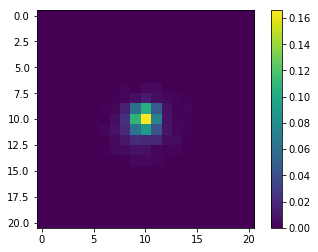

index 1, min values 0.000000


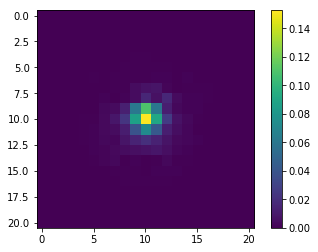

index 2, min values 0.000000


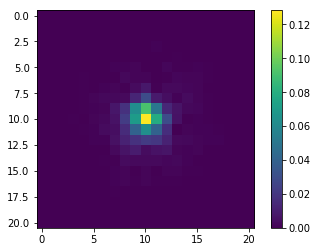

index 3, min values 0.000000


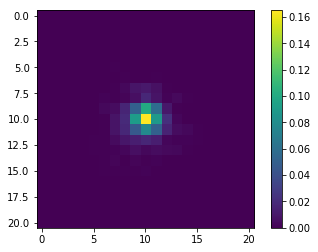

index 4, min values 0.000000


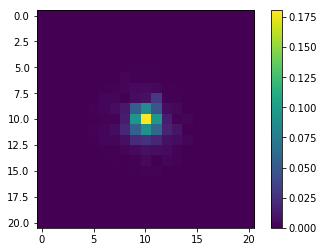

index 5, min values 0.000000


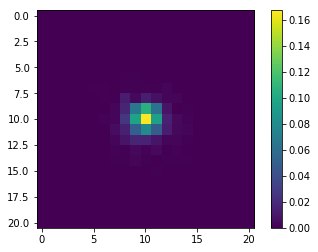

index 6, min values 0.000000


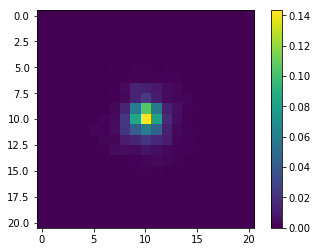

index 7, min values 0.000000


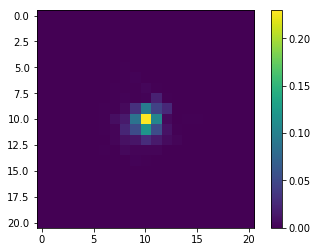

index 8, min values 0.000000


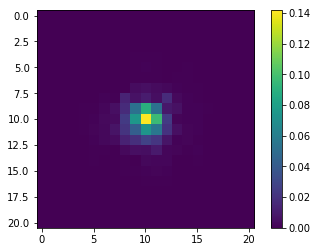

index 9, min values 0.000000


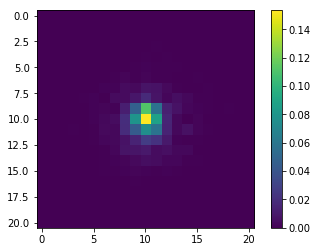

index 10, min values 0.000000


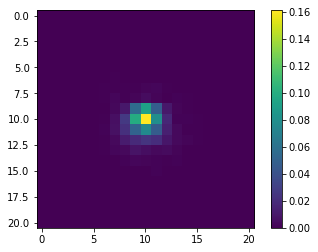

index 11, min values 0.000000


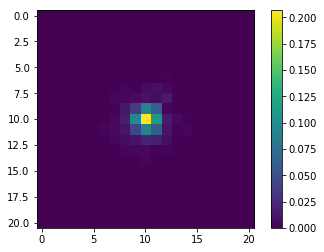

index 12, min values 0.000000


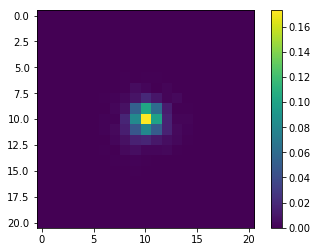

index 13, min values 0.000000


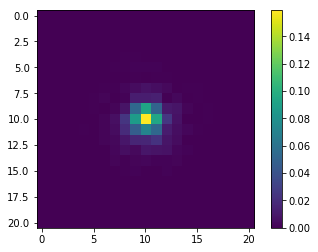

index 14, min values 0.000000


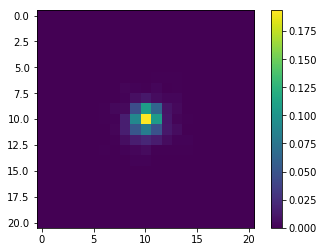

index 15, min values 0.000000


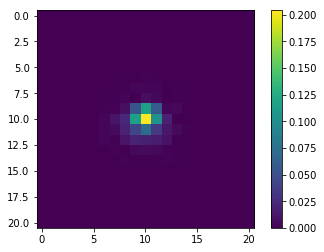

index 16, min values 0.000000


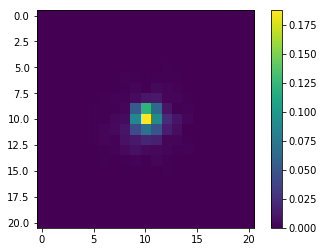

index 17, min values 0.000000


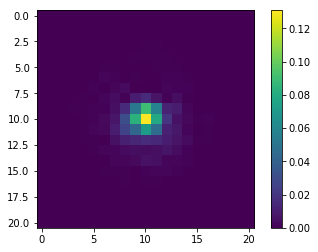

index 18, min values 0.000000


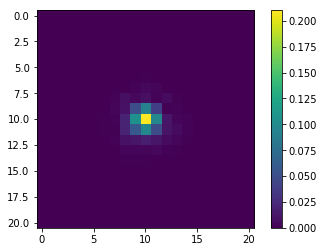

index 19, min values 0.000000


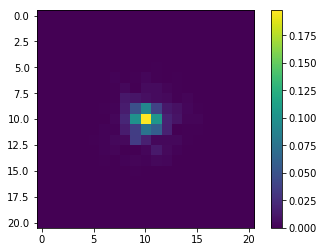

index 20, min values 0.000000


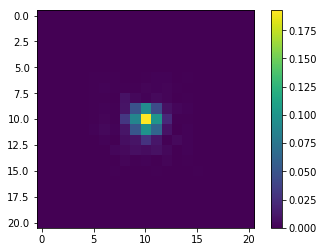

index 21, min values 0.000000


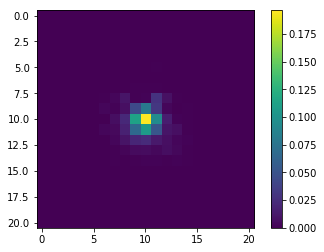

index 22, min values 0.000000


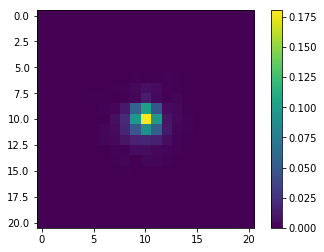

index 23, min values 0.000000


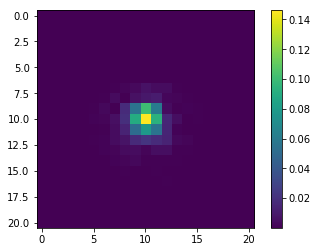

index 24, min values 0.000000


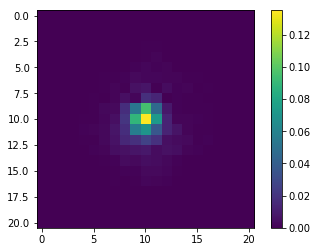

index 25, min values 0.000000


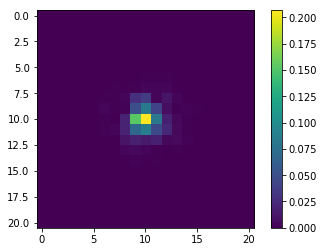

index 26, min values 0.000000


In [ ]:
#visualice filtered psfs
psfs = camera_obs_cond["psf"]
for i in range(psfs.shape[-1]):
    print('index %i, min values %f' % (i, np.min(psfs[...,i])))
    plt.imshow(psfs[...,i])
    plt.colorbar()
    plt.show()
psfs.shape